In [1]:
import warnings
warnings.filterwarnings('ignore')
import re
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from collections import Counter
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from tensorflow import keras
from keras.preprocessing.text import  Tokenizer
from keras.preprocessing.sequence import pad_sequences
from Constants import *

In [2]:
data = data_file.copy()

In [3]:
data.shape

(1600000, 6)

In [4]:
data = data.sample(frac = 1)
data = data[:100000]

In [5]:
data.rename(columns={
                    "polarity" : "Polarity",
                    "text" : "Text"
                    }, inplace = True)

In [6]:
data["Polarity"] = data["Polarity"].replace(4, 1)

In [7]:
num_classes = len(data["Polarity"].unique())
print(data["Polarity"].unique())
print(num_classes)

[1 0]
2


- Polarity Sentiment labels;
- 0 : Negative
- 1 : Positive

In [8]:
#data["Text"] = data["Text"].convert_dtypes()
#data["Text"].astype

In [9]:
data["Text"] = data["Text"].astype('str')

In [10]:
data.drop(["date", "id", "query", "user"], axis = 1, inplace = True)

In [11]:
data.isnull().sum()

Polarity    0
Text        0
dtype: int64

In [12]:
data.iloc[1]

Polarity                                                    0
Text        I'm craving something salty in my mouth!  Tire...
Name: 174677, dtype: object

In [13]:
data[data.columns[:1]]

,Polarity
1416692,1
174677,0
68009,0
663085,0
1072023,1
...,...
911346,1
137053,0
469254,0
511970,0


In [14]:
Positive_tweets = data["Polarity"][data.Polarity == 1]
Negative_tweets = data["Polarity"][data.Polarity == 0]

print("Number of Positive tweets: {}".format(len(Positive_tweets)))
print("Number of Negative tweets: {}".format(len(Negative_tweets)))

Number of Positive tweets: 49966
Number of Negative tweets: 50034


In [15]:
def word_count(words):
    return len(words.split())

In [16]:
text_corpus = []

for line in list(data["Text"]):
    words = line.split()
    for word in words:
        if len(word) > 2:
            text_corpus.append(word.lower())
            
Counter(text_corpus).most_common(10)

[('the', 32376),
 ('and', 18629),
 ('you', 14903),
 ('for', 13295),
 ('have', 8868),
 ('that', 8109),
 ("i'm", 7954),
 ('but', 7850),
 ('just', 7780),
 ('with', 7160)]

In [17]:
nltk.download("stopwords")
nltk.download("punkt")
nltk.download("wordnet")

[nltk_data] Error loading stopwords: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>
[nltk_data] Error loading punkt: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>
[nltk_data] Error loading wordnet: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>


False

In [18]:
stopword = set(stopwords.words("english"))
print(stopword)

{'hers', 'because', 'can', 'themselves', 'needn', "you've", 'hasn', 'above', 'an', 'of', 'why', 'him', 'a', 'once', 'had', "needn't", 'each', 'down', 's', 'those', 'all', 'i', 'myself', "you'll", 'through', 'herself', "wasn't", 'about', 't', 'both', 'out', 'between', 'here', 'ma', 'she', 'to', 'are', 'and', 'at', 'our', "mustn't", 'my', 'hadn', 'into', 'their', 'but', 'over', 'nor', 'not', 'whom', "couldn't", 'against', 'where', 'will', 'weren', 'this', "doesn't", 'more', 'until', 'ours', 'on', 'by', 'what', 'during', 'up', 'shouldn', 'after', 'it', 'in', 'no', 'been', 'how', 'if', 'were', 'himself', 'we', 'same', "aren't", 'shan', 'does', 'such', "mightn't", 'did', 'be', 'as', 'very', 'most', 'mustn', 'then', 'so', "she's", 'ain', 'itself', 'me', 'has', 've', 'than', 'them', 'that', 'theirs', 'd', 'some', "weren't", 'before', 'didn', 'mightn', 'doing', 'your', "shan't", 'just', 'wouldn', "hasn't", 'yourself', 'further', "shouldn't", 'only', "wouldn't", 'other', 'again', 'there', "isn'

In [19]:
url_format = r"((http://)[^ ]*(https://)[^ ]*|(www\.)[^ ]*)"
user_format = "@[^\s]+"

In [20]:
def preprocessed_tweets(tweet):
    
    tweet = tweet.lower()
    tweet = tweet[1:]
    
    tweet = re.sub(url_format, '', tweet)
    tweet = re.sub(user_format, '', tweet)
    
    tweet = tweet.translate(str.maketrans("", "", string.punctuation))
    
    word_tokens = word_tokenize(tweet)
    
    stopword_strip = [w for w in word_tokens if w not in stopword]
    
    word_lemmatize = WordNetLemmatizer()
    base_words = []
    for w in stopword_strip:
        if len(w) > 1:
            word = word_lemmatize.lemmatize(w)
            base_words.append(word)
            
    return ' '.join(base_words)

In [21]:
data["Preprocessed_tweets"] = data["Text"].apply(lambda x : preprocessed_tweets(x))
print("Text Preprocessing Done")

Text Preprocessing Done


In [22]:
data.head()

,Polarity,Text,Preprocessed_tweets
1416692,1,@scotmendenhall the Maui nix card has been cap...,scotmendenhall maui nix card captured
174677,0,I'm craving something salty in my mouth! Tire...,craving something salty mouth tired pretzel tho
68009,0,I'm totally wishing my melo worked,totally wishing melo worked
663085,0,Christina Kolotouros is speaking. We're getti...,hristina kolotouros speaking getting overview ...
1072023,1,@lovemk oh you should not be a loser and come ...,lovemk oh loser come hang tonight loser


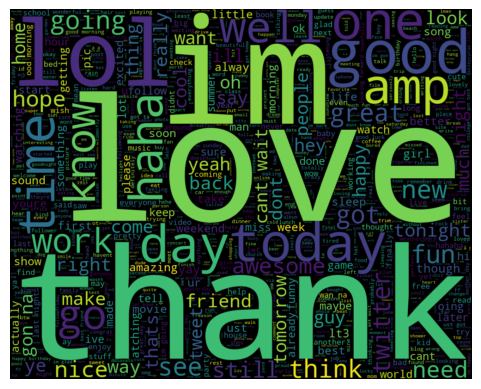

In [23]:
# WordCloud for Positive class

plt.Figure(figsize = (10, 8))
word_cloud = WordCloud(max_words = 1000, width = 1000, height = 800)
word_cloud.generate(" ".join(data[data.Polarity == 1].Preprocessed_tweets))
plt.axis("off")
plt.imshow(word_cloud, interpolation = "bilinear")

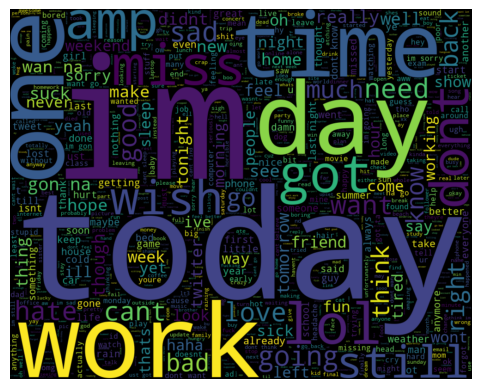

In [24]:
# WordCloud for Negative class

plt.Figure(figsize = (10, 8))
word_cloud = WordCloud(max_words = 1000, width = 1000, height = 800)
word_cloud.generate(" ".join(data[data.Polarity == 0].Preprocessed_tweets))
plt.axis("off")
plt.imshow(word_cloud, interpolation = "bilinear")

In [25]:
X = data["Preprocessed_tweets"].values
y = data[data.columns[:1]].values

In [26]:
vectoriser = TfidfVectorizer(sublinear_tf = True)
X = vectoriser.fit_transform(X)

In [27]:
#print(vectoriser.get_feature_names()[2])
#print(vectoriser.get_feature_names()[200])
#print(vectoriser.get_feature_names()[1500])

In [28]:
X_proc = data.Preprocessed_tweets
y_proc = data.Polarity.values

In [29]:
text_tokenizer = Tokenizer(num_words = MAX_FEATURES)
text_tokenizer.fit_on_texts(X_proc)
text_sequence = text_tokenizer.texts_to_sequences(X_proc)
tweets = pad_sequences(text_sequence, maxlen = SEQUENCE_LENGTH)

In [30]:
tweets

array([[   0,    0,    0, ...,    0,    0,  584],
       [   0,    0,    0, ..., 1209,  107,  245],
       [   0,    0,    0, ...,  285,  887,  881],
       ...,
       [   0,    0,    0, ...,   13,    6,   45],
       [   0,    0,    0, ...,    6,   50,  555],
       [   0,    0,    0, ...,   85,   42,  556]])

In [31]:
X_train, X_test, y_train, y_test = train_test_split(tweets, y_proc, test_size = 0.25, random_state = 420)

In [32]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers import TextVectorization
from time import time
from tensorflow.keras.callbacks import TensorBoard

In [33]:
model = keras.Sequential([
    layers.Embedding(MAX_FEATURES + 1, 32),
    layers.Bidirectional(layers.LSTM(32, activation = 'tanh')),
    layers.Dense(128, activation = 'relu'),
    layers.Dropout(0.25),
    layers.Dense(64, activation = 'relu'),
    layers.Dense(1, activation = 'sigmoid')
])

In [34]:
model.compile(
    optimizer = 'adam',
    loss = 'BinaryCrossentropy',
    metrics = ['accuracy']
)

In [35]:
tensorboard = TensorBoard(log_dir = "logs_2/{}".format(time()))

In [36]:
early_stopping = keras.callbacks.EarlyStopping("val_accuracy",
                               verbose = 1,
                               patience = 3)

In [37]:
history = model.fit(X_train, y_train,
                    validation_data = (X_test, y_test),
                    batch_size = BATCH_SIZE,
                    verbose = 1,
                    callbacks = [tensorboard, early_stopping],
                    epochs = 15
                    )

Epoch 1/15


4688/4688 [==============================] - 1919s 407ms/step - loss: 0.5253 - accuracy: 0.7352 - val_loss: 0.4952 - val_accuracy: 0.7546
Epoch 2/15
4688/4688 [==============================] - 1999s 426ms/step - loss: 0.4679 - accuracy: 0.7754 - val_loss: 0.4961 - val_accuracy: 0.7586
Epoch 3/15
4688/4688 [==============================] - 1961s 418ms/step - loss: 0.4371 - accuracy: 0.7918 - val_loss: 0.5085 - val_accuracy: 0.7573
Epoch 4/15
4688/4688 [==============================] - 1901s 405ms/step - loss: 0.4096 - accuracy: 0.8063 - val_loss: 0.5372 - val_accuracy: 0.7538
Epoch 5/15
4688/4688 [==============================] - 2081s 444ms/step - loss: 0.3825 - accuracy: 0.8197 - val_loss: 0.5455 - val_accuracy: 0.7485
Epoch 5: early stopping


In [38]:
history = history.history

In [39]:
val_loss = history['val_loss']
loss = history['loss']

val_accuracy = history["val_accuracy"]
accuracy = history["accuracy"]

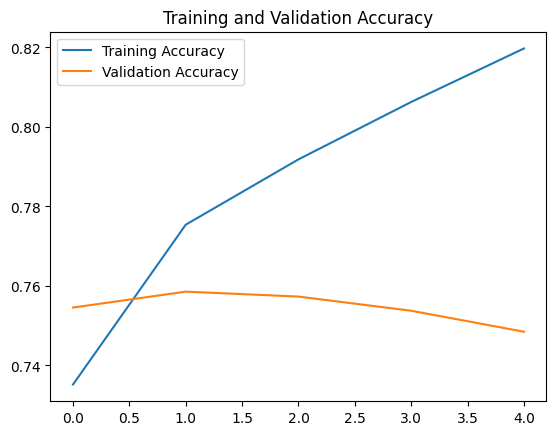

In [40]:
plt.plot(accuracy, label = "Training Accuracy")
plt.plot(val_accuracy, label = "Validation Accuracy")
plt.legend(loc = 'upper left')
plt.title("Training and Validation Accuracy")
plt.show()

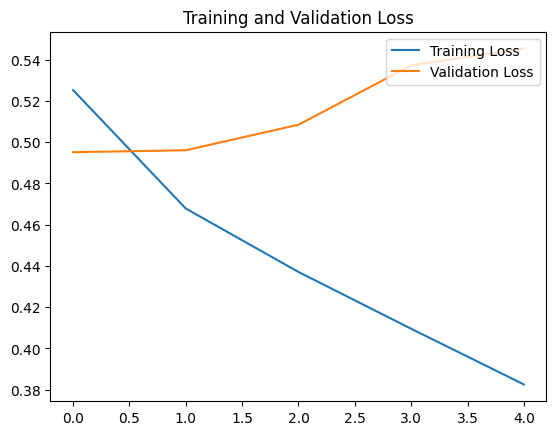

In [41]:
plt.plot(loss, label = "Training Loss")
plt.plot(val_loss, label = "Validation Loss")
plt.legend(loc = 'upper right')
plt.title("Training and Validation Loss")
plt.show()

In [42]:
model.save("tweets_2.h5")

In [43]:
model = tf.keras.models.load_model("tweets_2.h5")